# CTRL+MINd
**Mental Health In Tech**

## Libraries Importation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
CTRl_MIND_DF = pd.read_excel("merged_df_Lasttt.xlsx")

## Forecasting

**Our Target to Forecast**

**✔ Current mental health state**

**✔ Productivity impact** 

**✔ MH awareness**


### Forecasting SetUP

#### Imports and Settings

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings

#### Prepare Data

In [22]:
df = CTRl_MIND_DF.copy()  # Make a copy of original DataFrame
year_col = "Survey_Year"  # Year column

# Metrics to forecast
metrics = {
    "Current_MH_Disorder": "Do you currently have a mental health disorder?",
    "Productivity_Affected": "Do you believe your productivity is ever affected by a mental health issue?",
    "Awareness": "Do you know local or online resources to seek help for a mental health issue?",
}

#### Clean Yes/No Columns

In [23]:
YES_STRINGS = {"yes","y","1","true","t","possibly","maybe","oui","si","Yes"}

def clean_yes_no(val):
    """Convert yes-like values to 1, all others to 0, NaN stays as np.nan"""
    if pd.isna(val):
        return np.nan
    return 1 if str(val).strip().lower() in YES_STRINGS else 0

# Apply cleaning to all metric columns
for col in metrics.values():
    if col in df.columns:
        df[col] = df[col].apply(clean_yes_no)
    else:
        raise KeyError(f"Column not found: {col}")


#### Forecast Function

In [24]:
def forecast_metric(df, year_col, metric_col, end_year=2030, sarimax_order=(1,1,1)):
    """
    Forecast a metric using SARIMAX (fallback to Holt-Winters)
    Returns:
      - yearly: historical data
      - forecast_df: forecast with lower/upper CI
      - model_used: which model was used
    """
    # Historical yearly aggregation
    yearly = df.groupby(year_col)[metric_col].mean().reset_index().sort_values(year_col)
    yearly = yearly.rename(columns={metric_col:"Rate"})

    # Fill missing years
    if yearly.empty:
        return yearly, pd.DataFrame(columns=["Year","Forecast","Lower_CI","Upper_CI"]), "No-Data"
    years_full = np.arange(int(yearly[year_col].min()), int(yearly[year_col].max())+1)
    yearly = yearly.set_index(year_col).reindex(years_full).rename_axis(year_col).reset_index()
    yearly["Rate"] = yearly["Rate"].interpolate(limit_direction='both')

    # Forecast horizon
    last_year = int(yearly[year_col].max())
    H = end_year - last_year
    if H <= 0:
        return yearly, pd.DataFrame(columns=["Year","Forecast","Lower_CI","Upper_CI"]), "No-Forecast-needed"

    y = yearly["Rate"].values.astype(float)

    # Try SARIMAX first
    try:
        sarimax = SARIMAX(y, order=sarimax_order, enforce_stationarity=False, enforce_invertibility=False)
        res = sarimax.fit(disp=False)
        forecast_res = res.get_forecast(steps=H)
        mean_forecast = np.asarray(forecast_res.predicted_mean).flatten()
        ci = forecast_res.conf_int(alpha=0.05)
        lower = np.asarray(ci.iloc[:,0]).flatten() if isinstance(ci,pd.DataFrame) else np.asarray(ci[:,0]).flatten()
        upper = np.asarray(ci.iloc[:,1]).flatten() if isinstance(ci,pd.DataFrame) else np.asarray(ci[:,1]).flatten()
        model_used = "SARIMAX"
    except:
        # Fallback: Holt-Winters
        try:
            hw = ExponentialSmoothing(y, trend="add", initialization_method="estimated")
            hw_res = hw.fit(optimized=True)
            mean_forecast = np.asarray(hw_res.forecast(H)).flatten()
            lower = mean_forecast*0.9
            upper = mean_forecast*1.1
            model_used = "Holt-Winters"
        except:
            return yearly, pd.DataFrame(columns=["Year","Forecast","Lower_CI","Upper_CI"]), "Model-Failed"

    # Clip forecasts to [0,1]
    mean_forecast = np.clip(mean_forecast, 0, 1)
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)

    # Build forecast DataFrame
    forecast_years = np.arange(last_year+1, last_year+1+H)
    forecast_df = pd.DataFrame({
        "Year": forecast_years,
        "Forecast": mean_forecast,
        "Lower_CI": lower,
        "Upper_CI": upper
    })

    return yearly, forecast_df, model_used


#### Plot Function

In [25]:
def plot_forecast(yearly, forecast_df, year_col, metric_label, model_used):
    plt.figure(figsize=(10,5))
    plt.plot(yearly[year_col], yearly["Rate"], marker='o', label="Historical")
    if not forecast_df.empty:
        plt.plot(forecast_df["Year"], forecast_df["Forecast"], marker='o', linestyle='--', label="Forecast")
        plt.fill_between(forecast_df["Year"], forecast_df["Lower_CI"], forecast_df["Upper_CI"], alpha=0.2)
    plt.title(f"{metric_label} — Forecast to {forecast_df['Year'].max() if not forecast_df.empty else 'N/A'} ({model_used})")
    plt.xlabel("Year")
    plt.ylabel(metric_label + " (proportion)")
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.show()

    if not forecast_df.empty:
        display_df = forecast_df.copy()
        display_df[["Forecast","Lower_CI","Upper_CI"]] = (display_df[["Forecast","Lower_CI","Upper_CI"]]*100).round(2)
        print("\nForecast Table:")
        print(display_df.to_string(index=False))
    else:
        print("No forecast available.")

#### Run Forecast for All Metrics


Processing metric: Current_MH_Disorder -> column: Do you currently have a mental health disorder?
Model used: SARIMAX


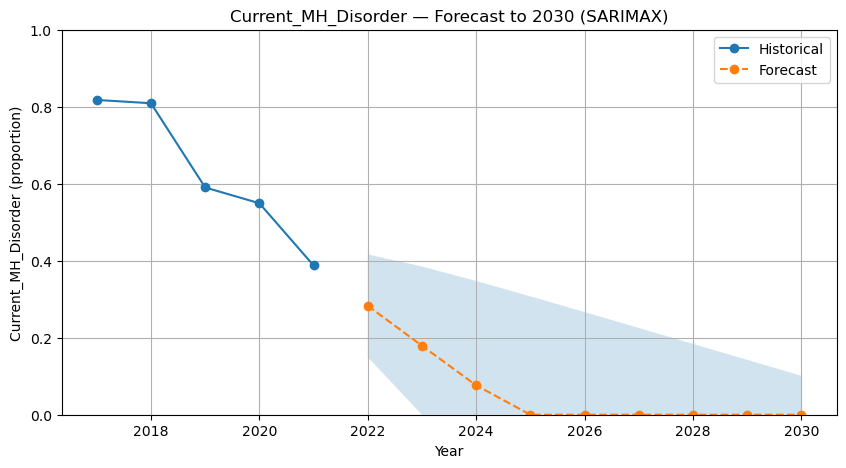


Forecast Table:
 Year  Forecast  Lower_CI  Upper_CI
 2022     28.30     14.95     41.65
 2023     17.92      0.00     38.50
 2024      7.64      0.00     34.74
 2025      0.00      0.00     30.76
 2026      0.00      0.00     26.67
 2027      0.00      0.00     22.54
 2028      0.00      0.00     18.40
 2029      0.00      0.00     14.26
 2030      0.00      0.00     10.13

Processing metric: Productivity_Affected -> column: Do you believe your productivity is ever affected by a mental health issue?
Model used: SARIMAX


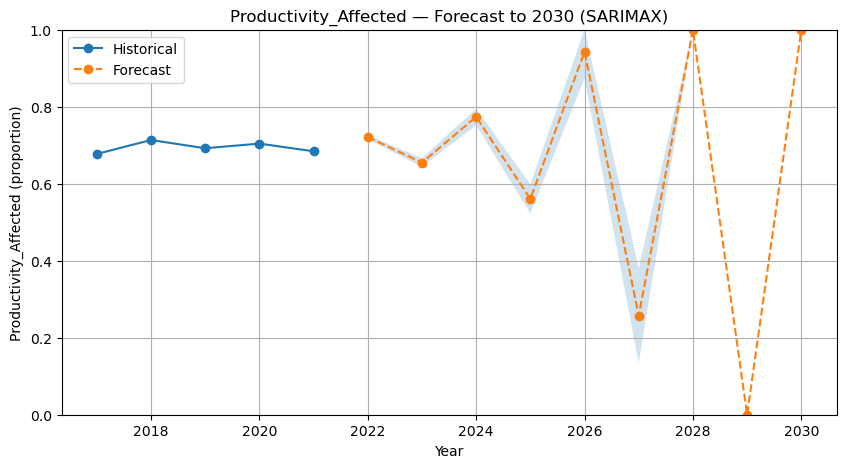


Forecast Table:
 Year  Forecast  Lower_CI  Upper_CI
 2022     72.11     71.51     72.71
 2023     65.49     64.37     66.61
 2024     77.37     75.22     79.51
 2025     56.06     52.25     59.88
 2026     94.28     87.35    100.00
 2027     25.73     13.36     38.10
 2028    100.00    100.00    100.00
 2029      0.00      0.00      0.00
 2030    100.00    100.00    100.00

Processing metric: Awareness -> column: Do you know local or online resources to seek help for a mental health issue?
Model used: SARIMAX


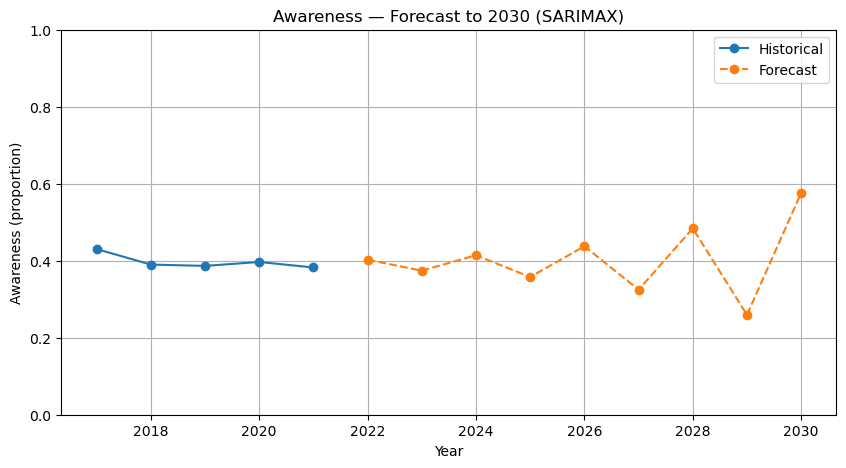


Forecast Table:
 Year  Forecast  Lower_CI  Upper_CI
 2022     40.26     40.25     40.27
 2023     37.42     37.40     37.43
 2024     41.43     41.40     41.45
 2025     35.77     35.74     35.80
 2026     43.75     43.71     43.80
 2027     32.48     32.43     32.54
 2028     48.39     48.31     48.47
 2029     25.94     25.82     26.05
 2030     57.63     57.47     57.79


In [26]:
results = {}
for key, col in metrics.items():
    print("\n" + "="*60)
    print("Processing metric:", key, "-> column:", col)
    yearly, forecast_df, model_used = forecast_metric(df, year_col, col, end_year=2030)
    print("Model used:", model_used)
    results[key] = {"yearly":yearly, "forecast":forecast_df, "model_used":model_used}
    plot_forecast(yearly, forecast_df, year_col, key, model_used)

#### Save Forecasts to CSV

In [27]:
for key, res in results.items():
    if not res["forecast"].empty:
        fname = f"forecast_{key}.csv"
        res["forecast"].to_csv(fname, index=False)
        print(f"Saved forecast to {fname}")

print("\nDone.")

Saved forecast to forecast_Current_MH_Disorder.csv
Saved forecast to forecast_Productivity_Affected.csv
Saved forecast to forecast_Awareness.csv

Done.


## ML (Random Forest)

### **Random Forest Model**

#### SETUP

**Our Target using ML**

**✔ Current mental health state**

**✔ Productivity** 

**✔ MH resource awareness**

In [41]:
from sklearn.preprocessing import LabelEncoder

df_ml = CTRl_MIND_DF.copy()

target = "Do you currently have a mental health disorder?"

df_ml = df_ml.dropna(subset=[target])

# Label Encoding
le = LabelEncoder()
df_ml[target] = le.fit_transform(df_ml[target])

print("Classes:", le.classes_)
print(df_ml[target].value_counts())


Classes: ["Don't Know" 'No' 'Possibly' 'Yes']
Do you currently have a mental health disorder?
3    1814
1     768
2     575
0     335
Name: count, dtype: int64


#### libraries Importation

In [42]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#### Load & Prepare Data

In [43]:
df = CTRl_MIND_DF.copy()
target = "Do you currently have a mental health disorder?"
df = df.dropna(subset=[target])


#### Encode TARGET Only

In [44]:
le_target = LabelEncoder()
df[target] = le_target.fit_transform(df[target])

#### Data Encoding

In [45]:
def convert_age(age):
    if isinstance(age, str) and "-" in age:
        a, b = age.split("-")
        return (int(a) + int(b)) / 2
    return age

if "What is your age?" in df.columns:
    df["What is your age?"] = df["What is your age?"].apply(convert_age)
label_encoders = {}

for col in df.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


#### Outlier Removal

In [46]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

condition = ~(
    (df[num_cols] < (Q1 - 1.5 * IQR)) |
    (df[num_cols] > (Q3 + 1.5 * IQR))
).any(axis=1)

df_clean = df[condition]

#### Train / Test Split

In [47]:
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

#### RandomForest Training Phase

In [48]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

#### Model Evaluation

In [49]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.79      0.98      0.87        53
           2       0.91      0.61      0.73        33
           3       1.00      0.78      0.88         9

    accuracy                           0.85       113
   macro avg       0.91      0.83      0.86       113
weighted avg       0.87      0.85      0.84       113

[[17  1  0  0]
 [ 1 52  0  0]
 [ 0 13 20  0]
 [ 0  0  2  7]]


#### Confusion Matrix

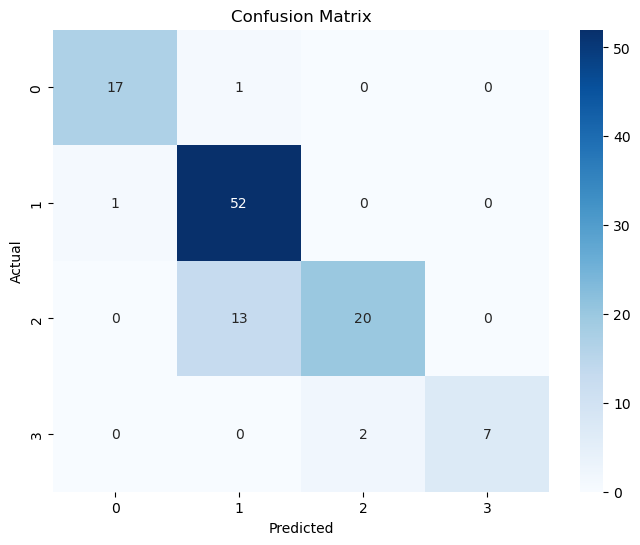

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Classification Report as Heatmap

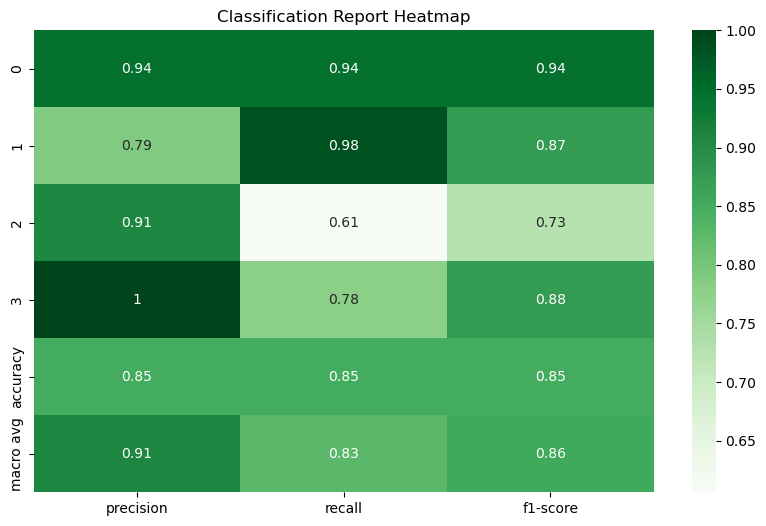

In [51]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).T

plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Greens")
plt.title("Classification Report Heatmap")
plt.show()

#### Feature Importance (Top 20 only)

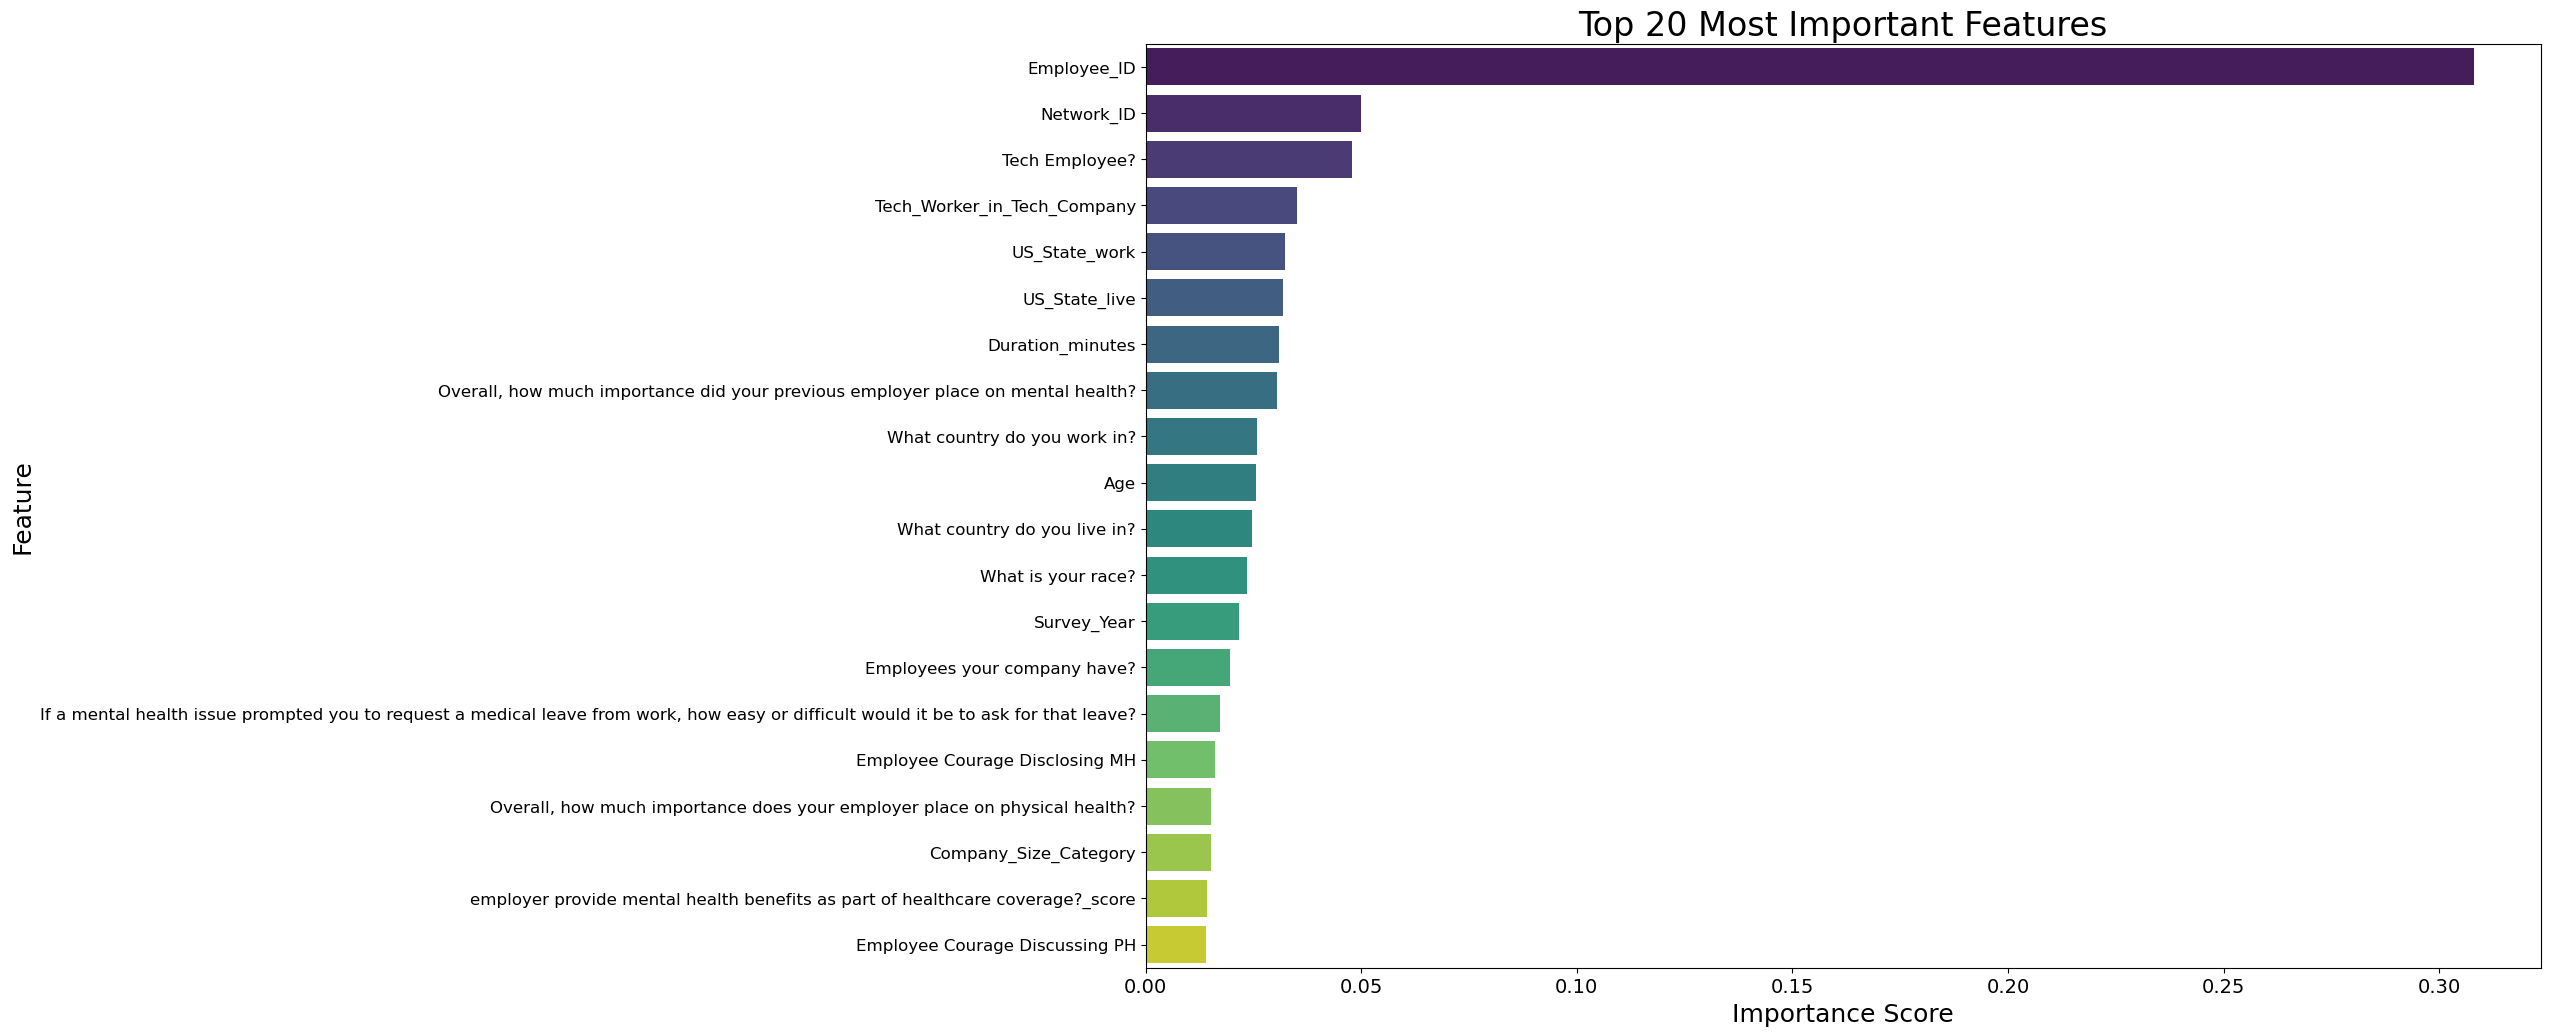

In [52]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(18,12))
sns.barplot(
    x=importances[indices][:20],
    y=X_train.columns[indices][:20],
    orient='h',
    palette="viridis"
)

plt.title("Top 20 Most Important Features", fontsize=24)
plt.xlabel("Importance Score", fontsize=18)
plt.ylabel("Feature", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

#### Class Distribution

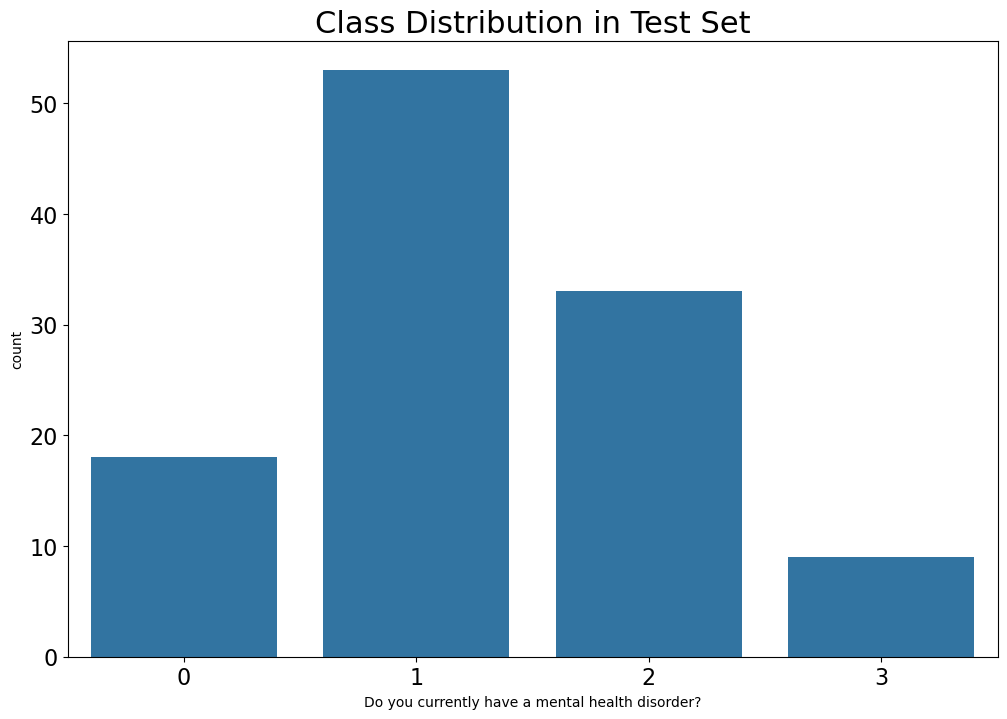

In [53]:
plt.figure(figsize=(12,8))
sns.countplot(x=y_test)
plt.title("Class Distribution in Test Set", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#### Actual vs Predicted

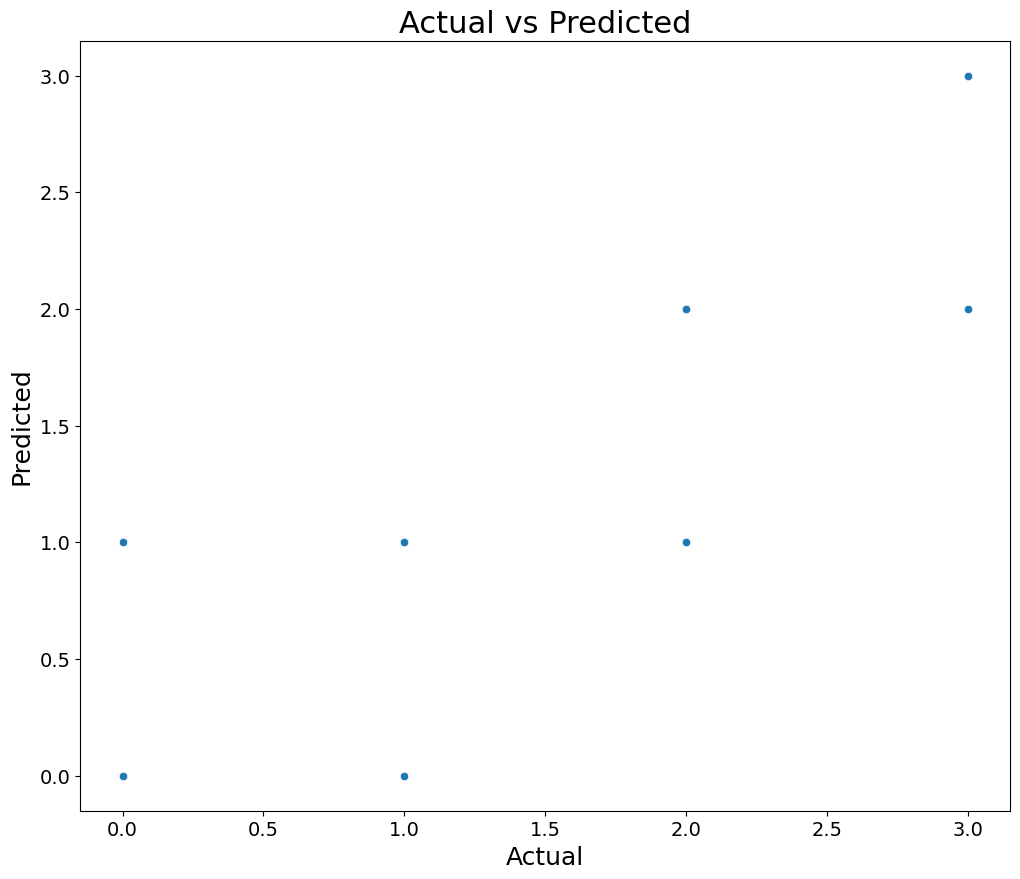

In [54]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred)
plt.title("Actual vs Predicted", fontsize=22)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### **CatBoost Model**

### SETUP

#### Import Libraries

In [58]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier, Pool

#### Load & Prepare Data

In [59]:
df = CTRl_MIND_DF.copy()

target = "Do you currently have a mental health disorder?"
df = df.dropna(subset=[target])


#### Encode TARGET Only

In [60]:
le_target = LabelEncoder()
df[target] = le_target.fit_transform(df[target])

#### Convert Age (18-24 → 21) + Keep categories as they are

In [61]:
def convert_age(age):
    if isinstance(age, str) and "-" in age:
        a, b = age.split("-")
        return (int(a) + int(b)) / 2
    return age

if "What is your age?" in df.columns:
    df["What is your age?"] = df["What is your age?"].apply(convert_age)

#### Split Features / Target

In [62]:
X = df.drop(columns=[target])
y = df[target]


#### Identify Categorical and Numeric Columns

In [63]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

#### Impute Missing Values

In [64]:
# numeric
imp_num = SimpleImputer(strategy="median")
X[numeric_cols] = imp_num.fit_transform(X[numeric_cols])

# categorical
imp_cat = SimpleImputer(strategy="most_frequent")
X[categorical_cols] = imp_cat.fit_transform(X[categorical_cols])

#### Apply Label Encoding ONLY to categorical features

In [65]:
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

#### Apply SMOTE

In [66]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

#### Train/Test Split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.25,
    random_state=42,
    stratify=y_resampled
)

#### CatBoost Model

In [91]:
model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.05,
    depth=8,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    verbose=False
)

#### CatBoost Model Training

In [92]:
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool  = Pool(X_test,  y_test,  cat_features=categorical_cols)

model.fit(train_pool)

#### ModelEvaluation

In [93]:
y_pred = model.predict(test_pool)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       454
           1       0.85      0.90      0.87       453
           2       0.86      0.87      0.87       454
           3       0.97      0.95      0.96       453

    accuracy                           0.92      1814
   macro avg       0.92      0.92      0.92      1814
weighted avg       0.92      0.92      0.92      1814


--- Confusion Matrix ---
[[425  24   5   0]
 [  7 407  37   2]
 [  0  47 397  10]
 [  2   0  20 431]]


#### Confusion Matrix

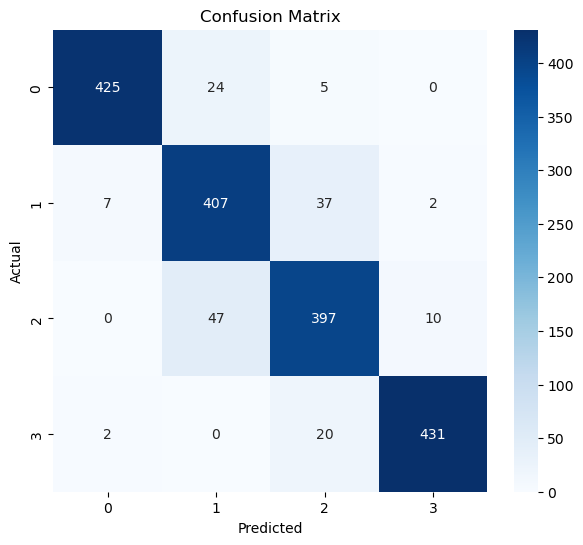

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Classification Report

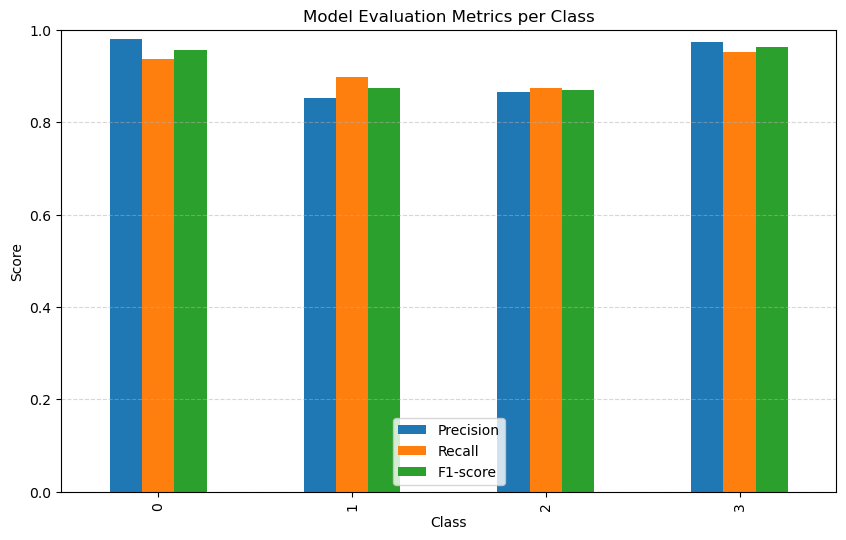

In [78]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred)

df_scores = pd.DataFrame({
    "Class": range(len(prec)),
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1
})

df_scores.plot(x="Class", kind="bar", figsize=(10,6))
plt.title("Model Evaluation Metrics per Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


#### Feature Importance

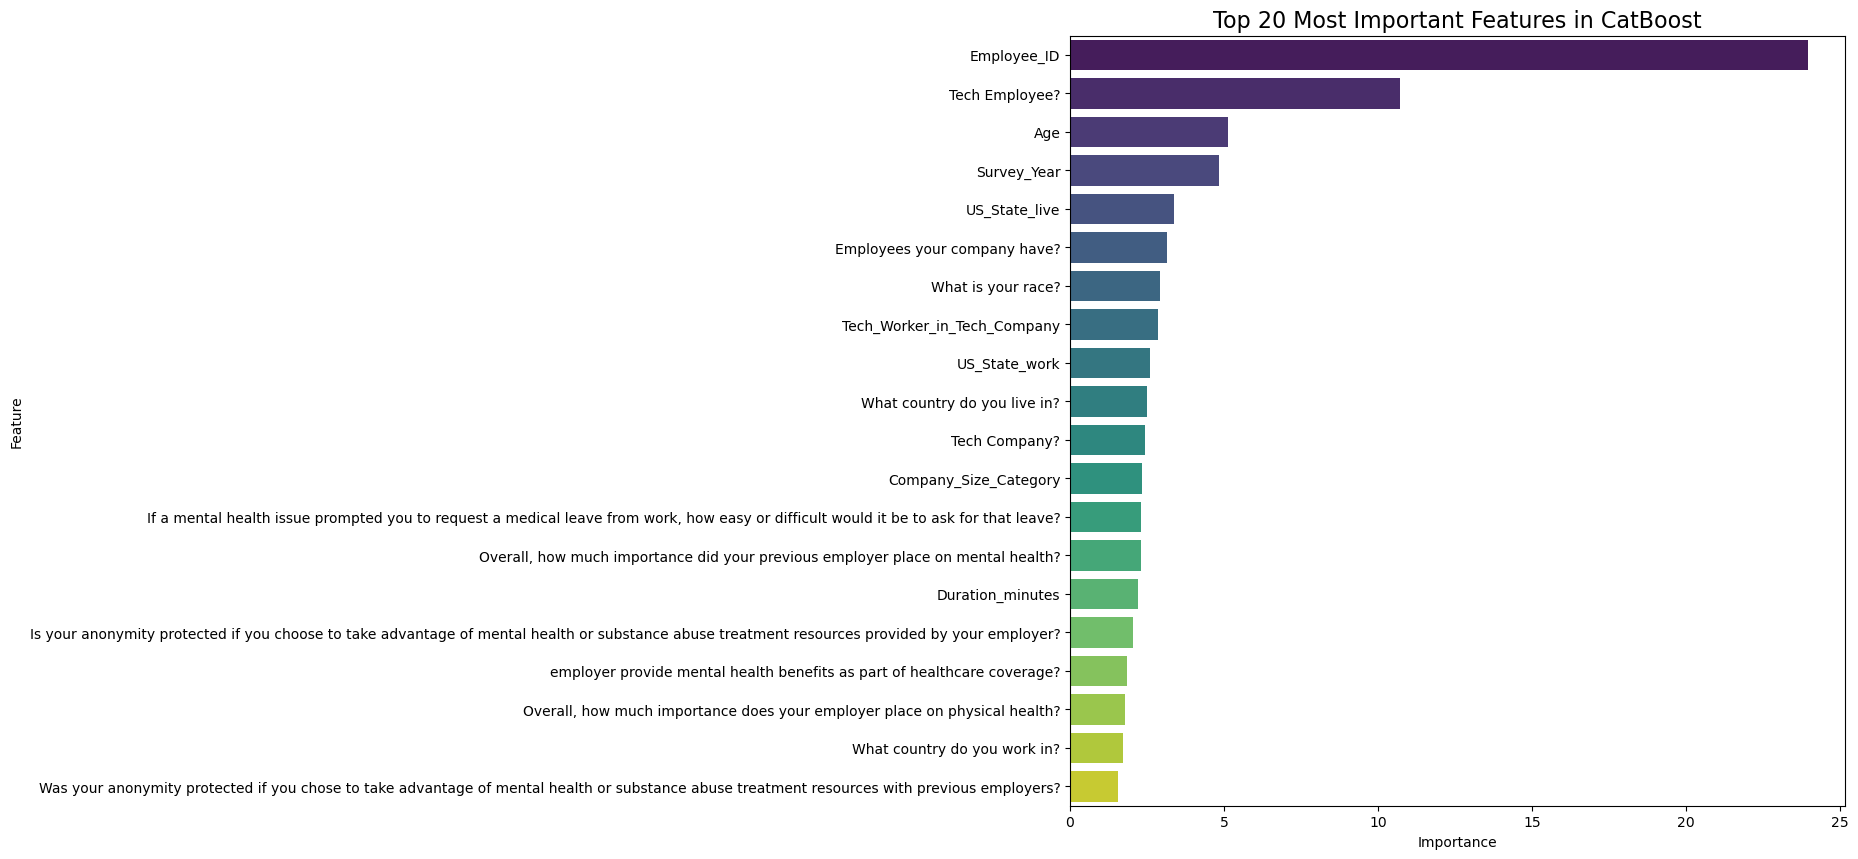

In [79]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values("Importance", ascending=False)

fi_top20 = fi_df.head(20)

plt.figure(figsize=(10, 10))
sns.barplot(data=fi_top20, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Most Important Features in CatBoost", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()